### Group 152 Proposal
# Advertisement Detection Using KNN Classification
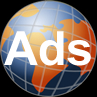

## 1. Introduction
   In recent years, the booming of online advertising has proved to be a highly effective tool to attract new customers for businesses, collect useful information about target audiences, diversify revenue streams and much more. It provides full marketing control in an efficient manner and at a low cost. Consequently, advertisements can be found on virtually every internet page. The purpose of our report is to use KNN classification to train a dataset and use the model to help us predict whether an image on an internet page is an advertisement or not. 

The goal of our project is to answer the following question: 
- Can we predict whether an image on an internet page is an advertisement or not using KNN classification?
- What will the accuracy of our model be, and what can be done to improve it?
- Can our model be implemented to real-life scenarios, and what would be the impact of it?

To get started with our project, we will apply our classification model to a dataset that was obtained from: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements
* Credits to Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The dataset is downloaded in a comma separated format. It contains 3 continuous variables (height, width, and ratio), as well as 1554 binary values (0 means no, 1 means yes) regarding the aspects of the image, which was then summed up into one new column called the "Attributes". The aspects of the image includes 19 caption features, 111 alt features, 495 base URL features, 472 destination URL features, and 457 in-image URL features. Several missing values are interpreted as a question mark ("?") in the dataset.

## 2. Preliminary exploratory data analysis:

### Reading Our Dataset

We start by importing the necessary libraries for our modelling

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Our dataset contains too many rows and columns that will take a long time to read. Hence, we are only taking the first 1000 rows of the dataset into account, and display the necessary columns.

In [2]:
# Read csv data without column name into R 
import_ad_data <- read_csv("Data/ad.data.csv", col_names = FALSE, col_select = c("X1", "X2", "X3", "X1560", "X1559"), n_max = 1000)

# Rename column names and filter out missing values
ad_data <- rename(import_ad_data, Height = X1, Width = X2, Ratio = X3, Attributes = X1560, Type = X1559)

glimpse(ad_data)

Rows: 1000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): X1, X2, X3, X1559
dbl (1): X1560

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,000
Columns: 5
$ Height     <chr> "125", "57", "33", "60", "60", "60", "59", "60", "60", "60"…
$ Width      <chr> "125", "468", "230", "468", "468", "468", "460", "234", "46…
$ Ratio      <chr> "1", "8.2105", "6.9696", "7.8", "7.8", "7.8", "7.7966", "3.…
$ Attributes <dbl> 14, 11, 22, 26, 24, 24, 27, 31, 23, 24, 32, 34, 33, 30, 22,…
$ Type       <chr> "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad…


### Cleaning and Wrangling Data Into Tidy Format

Let's filter out the missing values contained as "?" in each cell.

In [3]:
ad_filtered <- filter(ad_data, Height != "?" , Width != "?" , Ratio != "?")

Now let's check how many rows are classified as each type

In [4]:
total_type <- ad_filtered |>
              group_by(Type) |>
              summarize(n = n())
total_type

Type,n
<chr>,<int>
ad.,386
nonad.,370


The tibble above shows a good split between 'ad' and 'nonad' types as they are similar in proportion. It also implies that there are 244 rows being removed for having missing values.

Now set the two distinct image types as a factor, and convert the columns from character to numeric.

In [5]:
ad_factored <- ad_filtered |>
               mutate(Height = as.numeric(Height),
                      Width = as.numeric(Width),
                      Ratio = as.numeric(Ratio),
                      Type = as_factor(Type))
ad_factored

Height,Width,Ratio,Attributes,Type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,125,1.0000,14,ad.
57,468,8.2105,11,ad.
33,230,6.9696,22,ad.
60,468,7.8000,26,ad.
60,468,7.8000,24,ad.
60,468,7.8000,24,ad.
59,460,7.7966,27,ad.
60,234,3.9000,31,ad.
60,468,7.8000,23,ad.


### Data Splitting

Now we can split our data into training and test set. Our training set will contain 87% of the original data, so that the test set will consist of 100 observation rows.

In [21]:
set.seed(1) # Set the seed to a value of 1
ad_split <- initial_split(ad_factored, prop = 0.87, strata = Type)
ad_train <- training(ad_split)
ad_test <- testing(ad_split) 
glimpse(ad_train)
glimpse(ad_test)

Rows: 656
Columns: 5
$ Height     <dbl> 125, 57, 33, 60, 60, 60, 90, 90, 90, 33, 60, 60, 125, 30, 9…
$ Width      <dbl> 125, 468, 230, 468, 468, 468, 52, 60, 60, 230, 468, 468, 12…
$ Ratio      <dbl> 1.0000, 8.2105, 6.9696, 7.8000, 7.8000, 7.8000, 0.5777, 0.6…
$ Attributes <dbl> 14, 11, 22, 26, 24, 23, 34, 33, 30, 22, 28, 48, 27, 10, 32,…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…
Rows: 100
Columns: 5
$ Height     <dbl> 60, 59, 60, 60, 60, 90, 60, 60, 125, 125, 60, 60, 125, 60, …
$ Width      <dbl> 468, 460, 234, 468, 468, 60, 468, 468, 125, 125, 234, 120, …
$ Ratio      <dbl> 7.8000, 7.7966, 3.9000, 7.8000, 7.8000, 0.6666, 7.8000, 7.8…
$ Attributes <dbl> 24, 27, 31, 24, 27, 31, 46, 69, 58, 53, 28, 8, 37, 36, 9, 4…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…


Here we can check the proportion split of each set

In [22]:
data_proportions_train <- ad_train |>
                    group_by(Type) |>
                    summarize(n = n()) |>
                    mutate(percent = 100*n/nrow(ad_train))
data_proportions_train

data_proportions_test <- ad_test |>
                         group_by(Type) |>
                         summarize(n = n()) |>
                         mutate(percent = 100*n/nrow(ad_test))
data_proportions_test

Type,n,percent
<fct>,<int>,<dbl>
ad.,335,51.06707
nonad.,321,48.93293


Type,n,percent
<fct>,<int>,<dbl>
ad.,51,51
nonad.,49,49


It looks like both sets have a balanced proportion between 'ad' and 'nonad' types!

Next step is to scale all four predictors to have a mean of 0 and a standard deviation of 1.

In [38]:
ad_data_recipe <- recipe(Type ~ Height + Width + Ratio + Attributes, data = ad_factored) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors()) |> 
                  prep()

ad_data_standardized <- bake(ad_data_recipe, ad_factored)

### Visualizing Data

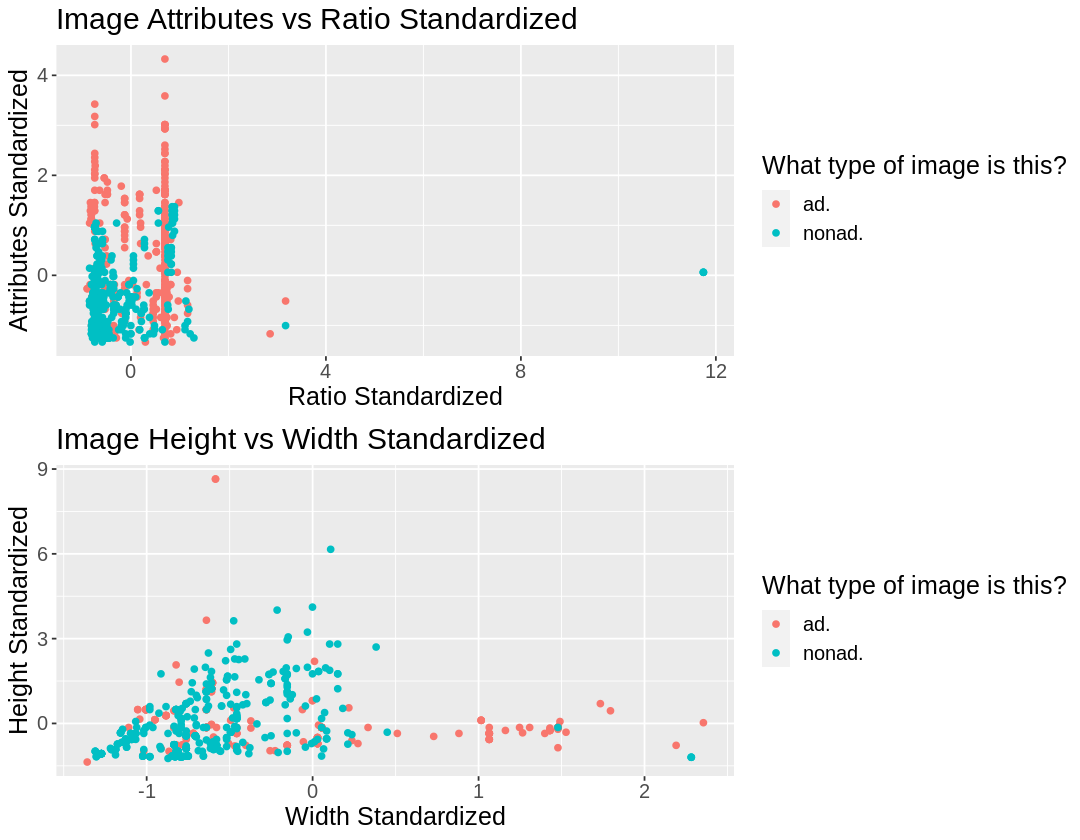

In [35]:
# Plot to see the relationship between image ratio and attributes to type

options(repr.plot.width = 9, repr.plot.height = 7)
ad_plot_ar  <- ad_data_standardized |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio Standardized") + 
               ylab("Attributes Standardized") +
               labs(colour = "What type of image is this?") +
               ggtitle("Image Attributes vs Ratio Standardized")+
               theme(text = element_text(size=15)) 

# Plot to see the relationship between image width and height to type

options(repr.plot.width = 9, repr.plot.height = 7)
ad_plot_hw  <- ad_data_standardized |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width Standardized") + 
               ylab("Height Standardized") +
               labs(colour = "What type of image is this?") + 
               ggtitle("Image Height vs Width Standardized")+
               theme(text = element_text(size=15)) 

plot_grid(ad_plot_ar, ad_plot_hw, ncol = 1)    

We can see that there are outliers from our standardized data. Let's remove them to prevent any performance errors in the future.

In [41]:
summary(ad_data_standardized)
# IQR = Q3 - Q1
# MIN = Q1 - 1.5 IQR
# MAX = Q3 + 1.5 IQR

     Height            Width             Ratio           Attributes     
 Min.   :-1.3654   Min.   :-1.3582   Min.   :-0.8969   Min.   :-1.3337  
 1st Qu.:-0.5644   1st Qu.:-0.7617   1st Qu.:-0.6971   1st Qu.:-0.7595  
 Median :-0.1428   Median :-0.4573   Median :-0.2058   Median :-0.2673  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.2577   3rd Qu.: 1.4783   3rd Qu.: 0.6966   3rd Qu.: 0.7170  
 Max.   : 8.6471   Max.   : 2.3548   Max.   :11.7441   Max.   : 4.3261  
     Type    
 ad.   :386  
 nonad.:370  
             
             
             
             

We can identify the outliers using quartile range formula, and remove the outliers from each predictors above

In [46]:
ad_standardized_clean <- filter(ad_data_standardized, 
                                Height >= -1.79755, 
                                Height <= 1.49085,
                                Width >= -4.1217,
                                Width <= 4.8383,
                                Ratio >= -2.78765,
                                Ratio <= 2.78715,
                                Attributes >= -2.97425,
                                Attributes <= 2.93175)

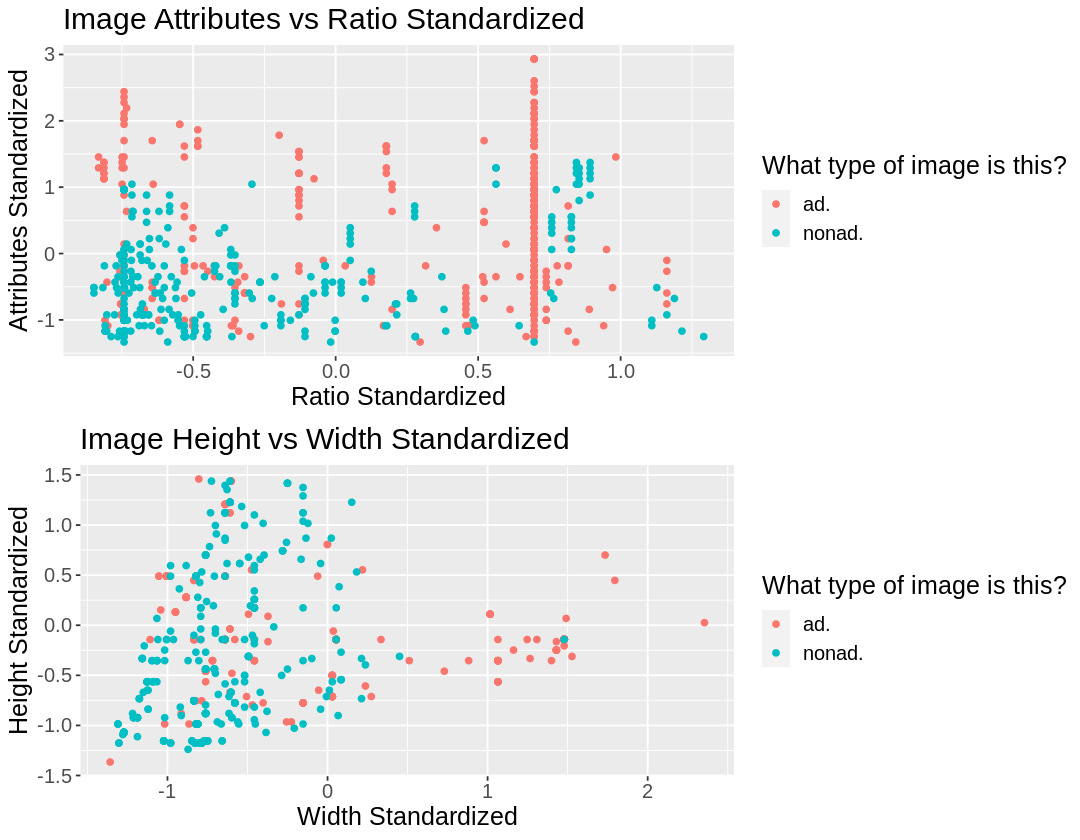

In [49]:
# Plot the new relationship between image ratio and attributes to type

options(repr.plot.width = 9, repr.plot.height = 7)
new_plot_ar <- ad_standardized_clean |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio Standardized") + 
               ylab("Attributes Standardized") +
               labs(colour = "What type of image is this?") +
               ggtitle("Image Attributes vs Ratio Standardized")+
               theme(text = element_text(size=15)) 

# Plot the new relationship between image width and height to type

options(repr.plot.width = 9, repr.plot.height = 7)
new_plot_hw <- ad_standardized_clean |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width Standardized") + 
               ylab("Height Standardized") +
               labs(colour = "What type of image is this?") + 
               ggtitle("Image Height vs Width Standardized")+
               theme(text = element_text(size=15)) 

plot_grid(new_plot_ar, new_plot_hw, ncol = 1)    

After removing the outliers, let's check what our new data is composed of!

In [50]:
new_proportions_train <- ad_standardized_clean |>
                         group_by(Type) |>
                         summarize(n = n())
                        
new_proportions_train

Type,n
<fct>,<int>
ad.,370
nonad.,319


In [12]:
# Do the training here with ad_train

## Expected outcomes and significance:
- We expect to find the ideal number of nearest neighbors (k) to use for the model, as well as the common traits for images that classify as advertisements. We also expect to find a classifier that is able to predict whether a test image is an internet advertisement or not. Lastly, we hope to launch a visualization that is able to represent the relationship between traits of the image (like height, width, ratio etc.) where background color indicates the decision of the classifier.

- Advertisements have become a staple in the digital experiences of all types of consumers, and software that can detect ads has many applications. It can be used to compare advertisement counts between websites. Advertisers can use this software to see how saturated potential sponsor candidate’s sites are, and this software has an obvious, but perhaps unethical, application in ad-blockers.

- This data analysis has the potential to return a plethora of questions to analyze in the future. How do different websites compare in advertisement counts? Does this affect the interactions generated with the ads? Is there a relationship between some of the predictors we used and the effectiveness of the advertisements? It also raises the important question: how can advertisers modify their advertisements to be less recognizable by software like this?

## Methods:
- In our file we are looking at the variables: Height, Width, Ratio, Attributes and Type. We are inputting them into the recipe formula such that we use Height, Width, Ratio and Attributes to predict Type. As height, width, ratio and type weren’t initially listed as numeric variables, we first passed them through as.numeric() to make them numeric variables to aid in the data analysis. We then split the data set into a testing and training set and mutated type into a percentage, to aid in visualizing the split between an ad and non-ad type.

- We are going to use a scatterplot to view the disparity between ad and non-ad types. One with standardized variables and predictors and one without. 